In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
Dataset_path="Downloads/exam"
IMG_SIZE=(224,224)
BATCH_SIZE=32
SEED=42

In [3]:
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    Dataset_path,
    validation_split=0.3,
    subset="training",
    seed=SEED,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True)
full_valid_ds=tf.keras.preprocessing.image_dataset_from_directory(
    Dataset_path,
    validation_split=0.3,
    subset="validation",
    seed=SEED,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True)

train_size=len(train_ds)
val_size=len(full_valid_ds)//2
test_size=len(full_valid_ds)-val_size

valid_ds=full_valid_ds.take(val_size)
test_ds=full_valid_ds.skip(val_size)

Found 1000 files belonging to 2 classes.
Using 700 files for training.
Found 1000 files belonging to 2 classes.
Using 300 files for validation.


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten, Dense



In [6]:
model=Sequential([
    Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3),padding='same'),
    MaxPooling2D((2,2)),
     Conv2D(64, (3,3), activation='relu', padding='same', name='conv2'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu',padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu',padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128,activation='relu'),
    Dense(1,activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2 (Conv2D)              (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

In [7]:
history=model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=1)

22/22 [==============================] - 75s 3s/step - loss: 2.1090 - accuracy: 0.4957 - val_loss: 0.8157 - val_accuracy: 0.4688


In [10]:
feature_extractor=tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)

def extract_features_labels(dataset):
    features, labels = [], []
    for batch_images, batch_labels in dataset:
        batch_features = feature_extractor(batch_images).numpy()
        features.append(batch_features)
        labels.append(batch_labels.numpy())
    return np.vstack(features), np.concatenate(labels)

X_train, y_train = extract_features_labels(train_ds)
X_test, y_test = extract_features_labels(test_ds)


In [14]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
dt=DecisionTreeClassifier(max_depth=5)
dt.fit(X_train,y_train)

print("Train accuracy surrogate:",accuracy_score(y_train,dt.predict(X_train)))
print("Test accuracy surrogate:",accuracy_score(y_test,dt.predict(X_test)))


Train accuracy surrogate: 0.7614285714285715
Test accuracy surrogate: 0.5571428571428572


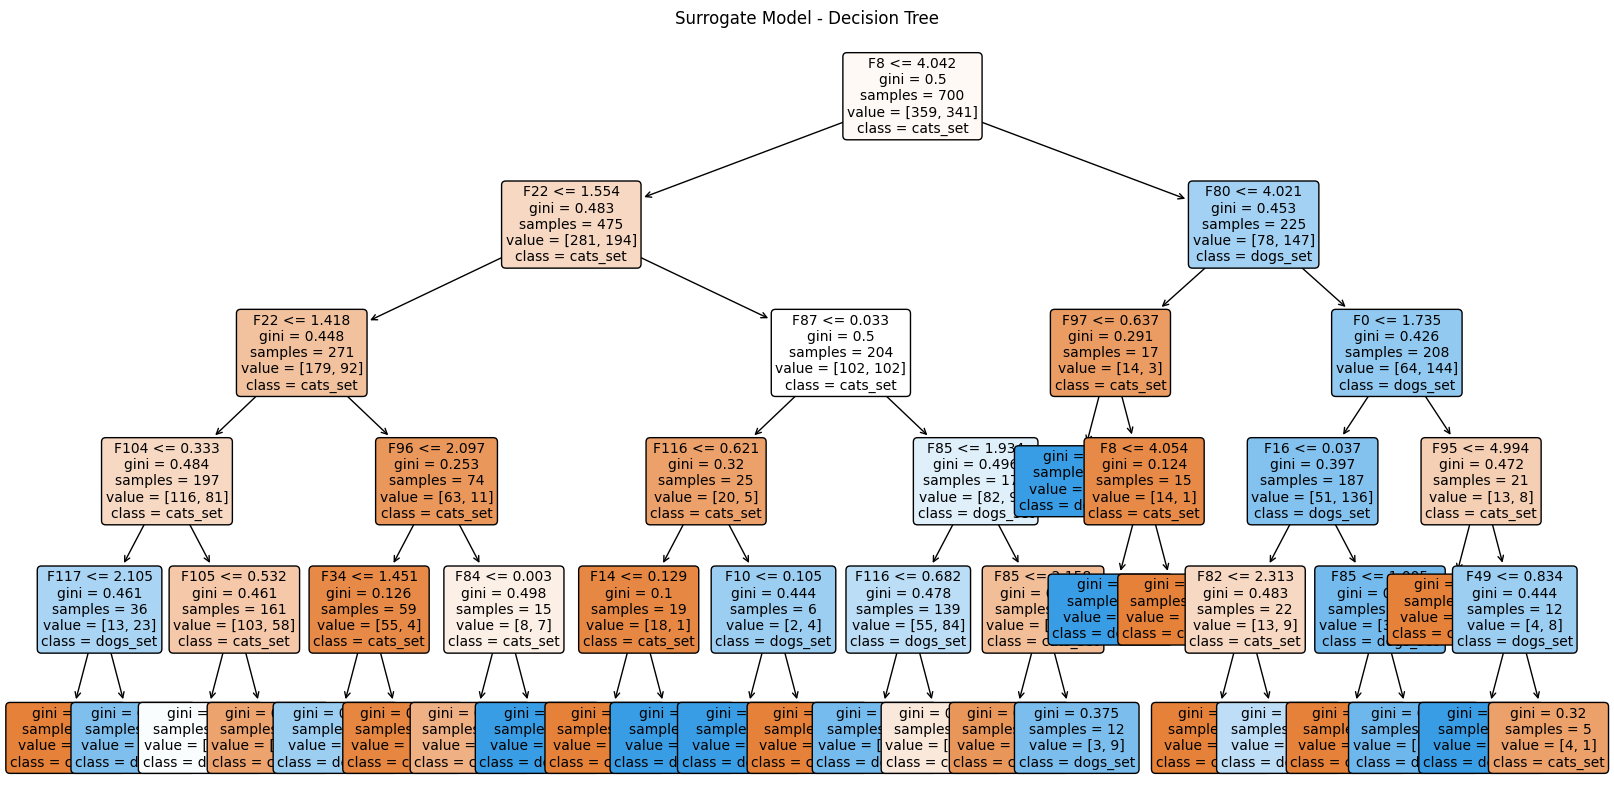

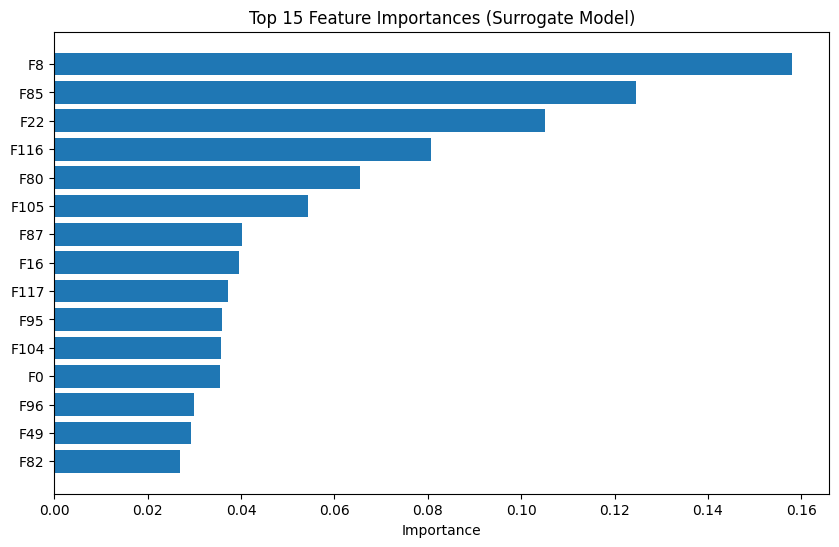

In [17]:
# Visualize Tree
class_names = train_ds.class_names

plt.figure(figsize=(20,10))
plot_tree(dt, filled=True,
          feature_names=[f"F{i}" for i in range(X_train.shape[1])],
          class_names=class_names,
          rounded=True,
          fontsize=10)
plt.title("Surrogate Model - Decision Tree")
plt.show()

importances = dt.feature_importances_
indices = np.argsort(importances)[::-1]  # Indices of features sorted by importance

# Only top N features
TOP_N = 15  # You can change to 10, 15, 20 depending on how many you want
top_indices = indices[:TOP_N]

plt.figure(figsize=(10, 6))
plt.barh(range(TOP_N), importances[top_indices], align="center")
plt.yticks(range(TOP_N), [f"F{i}" for i in top_indices])
plt.gca().invert_yaxis()  # Most important feature at top
plt.title(f"Top {TOP_N} Feature Importances (Surrogate Model)")
plt.xlabel("Importance")
plt.show()
